# Analysis on the Price of Airbnb Listings in Hong Kong

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
data = pd.read_csv('data/raw_listings.csv')

## Some general understanding about the data

In [3]:
data.shape

(6695, 75)

In [4]:
data.describe(include='all')

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6.695000e+03,6695,6.695000e+03,6695,6695,6695,6677,4433,6695,6.695000e+03,...,5628.000000,5627.000000,5627.000000,4895,6695,6695.000000,6695.000000,6695.000000,6695.000000,5641.000000
unique,NaN,6695,NaN,1,2,2915,6445,3898,6556,NaN,...,NaN,NaN,NaN,3939,2,NaN,NaN,NaN,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/13188,NaN,2023-09-06,city scrape,Rental unit in Vancouver · 1 bedroom · 1 bed ·...,Enjoy easy access to everything from this perf...,Yaletown might not be the oldest neighborhood ...,https://a0.muscache.com/pictures/78e62be7-b673...,NaN,...,NaN,NaN,NaN,Exempt,f,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,6695,5456,190,23,24,6,NaN,...,NaN,NaN,NaN,327,5103,NaN,NaN,NaN,NaN,NaN
mean,3.919462e+17,NaN,2.023091e+13,NaN,NaN,NaN,NaN,NaN,NaN,1.834403e+08,...,4.865183,4.812561,4.656277,NaN,NaN,6.479910,5.611352,0.838536,0.028678,1.992820
std,4.093610e+17,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,1.749817e+08,...,0.316995,0.293818,0.411447,NaN,NaN,17.840189,17.844357,2.289362,0.282572,2.056539
min,1.318800e+04,NaN,2.023091e+13,NaN,NaN,NaN,NaN,NaN,NaN,4.662000e+03,...,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.193765e+07,NaN,2.023091e+13,NaN,NaN,NaN,NaN,NaN,NaN,2.397700e+07,...,4.860000,4.750000,4.570000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.370000
50%,5.377272e+07,NaN,2.023091e+13,NaN,NaN,NaN,NaN,NaN,NaN,1.236479e+08,...,4.960000,4.890000,4.750000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,1.170000
75%,8.125552e+17,NaN,2.023091e+13,NaN,NaN,NaN,NaN,NaN,NaN,3.293645e+08,...,5.000000,5.000000,4.870000,NaN,NaN,3.000000,2.000000,0.000000,0.000000,3.140000


In [5]:
data.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

Since this project is about predicting the price, we could drop some columns that are not useful, or columns that are representing the similar information. We have reduced the dimension to 38 features.

In [6]:
drop_cols = ['name','id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url'
             ,'host_name', 'host_location', 'host_about', 'host_response_time', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications',
            'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights',	
            'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
            'calendar_updated', 'has_availability', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
            'first_review',	'last_review', 'license', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'latitude', 'longitude', 'availability_30', 'availability_60', 'availability_90']
data = data.drop(columns=drop_cols)
data.shape

(6695, 32)

### Data Cleaning

In [7]:
data['hasamenities'] = data['amenities'].apply(lambda x: 'yes' if x else 'no')
data.drop(columns=['amenities'],inplace=True)

In [8]:
# Drop all if the availability_365 is 0, since they are not available
data = data[(data.availability_365>0)]

# if the text column is na, fill them with empty space
text_columns = ['description', 'neighborhood_overview' ]
data[text_columns] = data[text_columns] .fillna('')

# fill the na value of the numeric features with 0
num_feats = data.select_dtypes(include='number').columns.tolist()
data[num_feats] = data[num_feats].fillna(0)

# change the type of the price to a number format
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# change the type of the rate to a number format
data['host_response_rate'] = data['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
data['host_acceptance_rate'] = data['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

# change the date column to duration
data['host_since'] = pd.to_datetime(data['host_since'], format='mixed')
data['host_duration_days'] = (datetime.now() - data['host_since']).dt.days
data = data.drop('host_since', axis=1)


### Split the data into training set and testing set

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

### EDA

In [10]:
num_feats = train_df.select_dtypes(include='number')
num_feats = num_feats.columns.tolist()

In [11]:
import altair as alt
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

In [12]:
display_feats = ['price', 'minimum_nights', 'host_total_listings_count', 'availability_365', 'review_scores_rating','reviews_per_month']
num_col_hists = alt.Chart(train_df[display_feats]).mark_bar().encode(
    x = alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=50)),
     y='count()',
).properties(
    width=200,
    height=200
).repeat(
    display_feats,
    columns=3 
)
num_col_hists

alt.RepeatChart(...)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

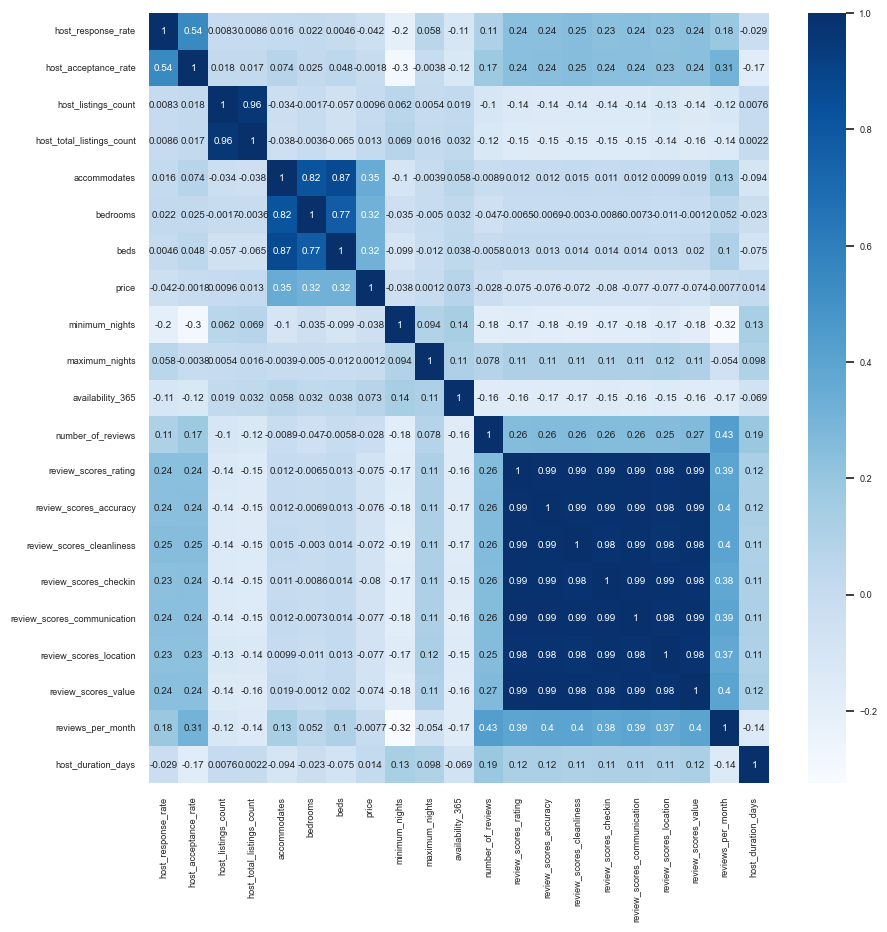

In [14]:
cor = train_df[num_feats].corr()
plt.figure(figsize=(10, 10))
sns.set(font_scale=0.6)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

Insights:
1. Our target variable (price) is highly skewed. It might be better to normalized it.
2. It seems that the review score is highly correlated to each other, so it would be wise to only keep one of them.
3. There is also high correlation between host_listing_count and host_total_listing_coung. So we only keep one of them.

### Preprocessing and Transformation

In [15]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

In [16]:
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [17]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")
nltk.download("punkt")
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bill/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
def get_positivity(text):
    """
    Returns the compound score representing the positivity, ranges from 0 to 1, where 1 indicates a highly positive sentiment.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    sentiment of the text: (str)
    """
    scores = sid.polarity_scores(text)["pos"]
    return scores


In [19]:
train_df = train_df.assign(desc_positivity=train_df['description'].apply(get_positivity))
train_df = train_df.assign(neighbor_overview_positivity=train_df['neighborhood_overview'].apply(get_positivity))

test_df = test_df.assign(desc_positivity=train_df['description'].apply(get_positivity))
test_df = test_df.assign(neighbor_overview_positivity=train_df['neighborhood_overview'].apply(get_positivity))

In [20]:
X_train, y_train = train_df.drop(columns=['price']), train_df['price']
X_test, y_test = test_df.drop(columns=['price']), test_df['price']

In [21]:
X_train.columns

Index(['description', 'neighborhood_overview', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'hasamenities', 'host_duration_days', 'desc_positivity',
       'neighbor_overview_positivity'],
      dtype='object')

In [22]:
num_feats = ['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'accommodates', 'bedrooms', 'beds',
            'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month',
            'host_duration_days', 'desc_positivity', 'neighbor_overview_positivity']
cat_feats = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
            'room_type', 'bathrooms_text', 'instant_bookable', 'hasamenities']
text_feat_1 = 'description'
text_feat_2 ='neighborhood_overview'
drop_feats = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_listings_count']

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

In [24]:
numeric_imputer = SimpleImputer(strategy='constant', fill_value=0)  # Impute missing values with 0 for numeric features
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Impute missing values with mode for categorical features

preprocessor = make_column_transformer(    
    (make_pipeline(numeric_imputer, StandardScaler()), num_feats),  # scaling on numeric features 
    (make_pipeline(categorical_imputer, OneHotEncoder(handle_unknown='ignore')), cat_feats),  # OHE on categorical features
    (CountVectorizer(stop_words="english", max_features=100), text_feat_1),
    (CountVectorizer(stop_words="english", max_features=100), text_feat_2),
    ("drop", drop_feats),  # drop the drop features
)

### Comparing models

In [25]:
#1. Linear Ridge
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

cross_val_results = {}
ridge = make_pipeline(preprocessor, RidgeCV())
ridge_with_target_transform = TransformedTargetRegressor(
    regressor=ridge,
    func=np.log1p,  
    inverse_func=np.expm1 
)
cv_df = pd.DataFrame(cross_validate(ridge_with_target_transform, X_train, y_train, return_train_score=True, cv = 10))
cross_val_results['ridge'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['ridge']

,mean,std
fit_time,0.431,0.018
score_time,0.029,0.000
test_score,0.399,0.248
train_score,0.706,0.066


In [26]:
# 2. A polynomial linear model
preprocessor_poly = make_column_transformer(    
    (make_pipeline(numeric_imputer, PolynomialFeatures(degree=2),StandardScaler()), num_feats),  # scaling on numeric features 
    (make_pipeline(categorical_imputer, OneHotEncoder(handle_unknown='ignore')), cat_feats),  # OHE on categorical features
    (CountVectorizer(stop_words="english", max_features=100), text_feat_1),
    (CountVectorizer(stop_words="english", max_features=100), text_feat_2),
    ("drop", drop_feats),  # drop the drop features
)

In [27]:
cross_val_results = {}
ridge_poly = make_pipeline(preprocessor_poly, RidgeCV())
ridge_poly_target_transform = TransformedTargetRegressor(
    regressor=ridge_poly,
    func=np.log1p,  
    inverse_func=np.expm1 
)
cv_df = pd.DataFrame(cross_validate(ridge_poly_target_transform, X_train, y_train, return_train_score=True, cv = 10))
cross_val_results['poly_ridge'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['poly_ridge']

,mean,std
fit_time,9.850000e-01,2.010000e-01
score_time,3.000000e-02,1.000000e-03
test_score,-2.108126e+08,6.666479e+08
train_score,3.290000e-01,1.440000e-01


In [28]:
# 3. A lgbm model
from lightgbm import LGBMRegressor
# Setup the pipeline
lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
ttr_lgbm = TransformedTargetRegressor(regressor=lgbm, func=np.log1p, inverse_func=np.expm1)
cv_df = pd.DataFrame(cross_validate(ttr_lgbm, X_train, y_train, return_train_score=True, cv = 10))
cross_val_results['lgbm'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['lgbm']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 271
[LightGBM] [Info] Start training from score 5.262223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 270
[LightGBM] [Info] Start training from score 5.262207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

,mean,std
fit_time,0.697,0.034
score_time,0.032,0.002
test_score,0.434,0.222
train_score,0.663,0.054


In [29]:
# 4. Random forest
from sklearn.ensemble import RandomForestRegressor

# Setup the pipeline
rforest = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=20, random_state=123, n_jobs=-1))
ttr_rforest = TransformedTargetRegressor(regressor=rforest, func=np.log1p, inverse_func=np.expm1)
cv_df = pd.DataFrame(cross_validate(ttr_rforest, X_train, y_train, return_train_score=True, cv = 10))
cross_val_results['random_forest'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['random_forest']

,mean,std
fit_time,1.197,0.059
score_time,0.045,0.002
test_score,0.365,0.204
train_score,0.573,0.065


Seems that all models suffer from pretty bad overfitting, let's try some feature selection

## Feature selection

### 1. Select from model

In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso


select_lr = SelectFromModel(Lasso(), threshold="median")
pipe_rf_model_based = make_pipeline(
    preprocessor, select_lr, RandomForestRegressor(n_estimators=20, random_state=123, n_jobs=-1)
) 

In [31]:
ttr_rforest_model_based = TransformedTargetRegressor(regressor=pipe_rf_model_based, func=np.log1p, inverse_func=np.expm1)
cv_df = pd.DataFrame(cross_validate(ttr_rforest_model_based, X_train, y_train, return_train_score=True, cv = 10, n_jobs=-1))
cross_val_results['rf_model_based'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['rf_model_based']

,mean,std
fit_time,6.293,2.356
score_time,0.058,0.010
test_score,0.365,0.204
train_score,0.573,0.065


### 2. RFE

In [32]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

rfecv = RFECV(Ridge())
pipe_rf_rfecv = make_pipeline(
    preprocessor, select_lr, RandomForestRegressor(n_estimators=20, random_state=123, n_jobs=-1)
)
ttr_rforest_rfe_cv = TransformedTargetRegressor(regressor=pipe_rf_rfecv, func=np.log1p, inverse_func=np.expm1)
cv_df = pd.DataFrame(cross_validate(ttr_rforest_rfe_cv , X_train, y_train, return_train_score=True, cv = 10, n_jobs=-1))
cross_val_results['rf_rfecv'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['rf_rfecv']


,mean,std
fit_time,5.538,1.953
score_time,0.057,0.011
test_score,0.365,0.204
train_score,0.573,0.065
